In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from scipy.stats import chi2

In [2]:
def check_outlier(data, low_th, high_th):
   Q3 = np.percentile(data, high_th, method='midpoint')
   Q1 = np.percentile(data, low_th, method='midpoint')
   IQR = Q3 - Q1
   lower = Q1 - 1.5*IQR
   upper = Q3 + 1.5*IQR
   mask = (data > upper) | (data < lower)
   return mask


def remove_outlier(df, labels, low_th, high_th):
   result = df.copy()
   for l in labels:
      name_new_col = f'ol_{l}'
      data_new = check_outlier(result[l], low_th, high_th)
      result[name_new_col] = data_new
      result = result[result[name_new_col] != True]
      result = result.drop(labels=name_new_col, axis=1)
   return result


def bootstrap(data, total_size=10000):
    vnd_population = []
    demand_population = []
    supply_population = []
    
    size = len(data)
    
    while len(vnd_population) < total_size:
        try:
            indices = np.random.randint(low=0, high=size, size=size)
            vnd_sample = data['VND'].iloc[indices]
            demand_sample = data['demand'].iloc[indices]
            supply_sample = data['supply'].iloc[indices]
            vnd_population.append(np.mean(vnd_sample))
            demand_population.append(np.mean(demand_sample))
            supply_population.append(np.mean(supply_sample))

        except IndexError:
            continue
    
    df = pd.DataFrame({
            'VND': vnd_population,
            'demand': demand_population,
            'supply': supply_population
        })

    df = remove_outlier(df, labels=['VND'], low_th=10, high_th=90)

    return df


def mid_data(df):

    df = bootstrap(df)

    y = df['VND'].values
    x_d = df['demand'].values
    x_s = df['supply'].values
    
    max_ = max(np.max(x_d), np.max(x_s))
    x_sm = np.linspace(0, max_, int(max_*1000))
    
    # procesing demand
    z_d = np.polyfit(x_d, y, 1)
    y_hat_d = z_d[1] + z_d[0]*x_sm
    y_hat_d = np.round(y_hat_d, 2)

    # procesing demand
    z_s = np.polyfit(x_s, y, 1)
    y_hat_s = z_s[1] + z_s[0]*x_sm
    y_hat_s = np.round(y_hat_s, 2)

    index_equal = np.where(y_hat_d == y_hat_s)[0]

    return np.median(y_hat_d[index_equal])


def estimation_sigma(data):
    n = len(data)
    S = data.std()
    up = ( (n-1)*S**2 ) / ( chi2.isf(1-0.05/2, n-1) )
    down = ( (n-1)*S**2 ) / ( chi2.isf(0.05/2, n-1) )
    return np.sqrt(down), np.sqrt(up)

In [3]:
path = 'data/'
files = os.listdir(path)

ID = []
Balance_prices = []
Present_prices = []
Compares = []
Percents = []
Lower_sigma = []
Upper_sigma = []

for file in files:
    df = pd.read_csv(f'{path}{file}')
    
    # Skip files with less than or equal to 30 rows
    if len(df) <= 30:
        continue

    # Extract ID from file name
    id = file.replace('.csv', '').split('_')[1]
    
    # Calculate balance price, present price, and sigma
    balance_price = mid_data(df)
    present_price = df['VND'].values[0]
    compare = present_price - balance_price
    percent = np.round(np.abs(compare)/balance_price * 100, 2)
    sigma_low, sigma_high = estimation_sigma(df['VND'].values)

    # Append data to lists
    ID.append(id)
    Balance_prices.append(balance_price)
    Present_prices.append(present_price)
    Compares.append(compare)
    Percents.append(percent)
    Lower_sigma.append(sigma_low)
    Upper_sigma.append(sigma_high)

# Create DataFrame from collected data
data = pd.DataFrame({
    'ID': ID,
    'Balance Price': Balance_prices,
    'Present Price': Present_prices,
    'Present - Balance': Compares,
    'Percent': Percents,
    'Lower Sigma': Lower_sigma,
    'Upper Sigma': Upper_sigma
})

/home/dang/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dang/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dang/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dang/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dang/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dang/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(

In [4]:
data = data.dropna()
data

,ID,Balance Price,Present Price,Present - Balance,Percent,Lower Sigma,Upper Sigma
0,VNM,87.15,67.70,-19.45,22.32,15.930499,17.348936
1,HPG,25.38,30.55,5.17,20.37,11.863004,12.919275
2,BCM,63.84,65.30,1.46,2.29,14.202445,15.583617
4,SAB,189.69,57.20,-132.49,69.85,38.141398,41.537474
6,POW,10.16,11.45,1.29,12.70,1.982760,2.159304
8,TPB,26.16,19.10,-7.06,26.99,7.875109,8.576302
10,VIC,82.04,47.60,-34.44,41.98,24.022249,26.161169
12,SHB,14.36,11.60,-2.76,19.22,4.685689,5.240266
13,GAS,92.63,80.30,-12.33,13.31,14.970336,16.303281
14,FPT,77.74,117.10,39.36,50.63,17.750152,19.330609


In [5]:
data_clear = data.where(data['Present - Balance'] < 0).dropna()
data_clear

,ID,Balance Price,Present Price,Present - Balance,Percent,Lower Sigma,Upper Sigma
0,VNM,87.15,67.70,-19.45,22.32,15.930499,17.348936
4,SAB,189.69,57.20,-132.49,69.85,38.141398,41.537474
8,TPB,26.16,19.10,-7.06,26.99,7.875109,8.576302
10,VIC,82.04,47.60,-34.44,41.98,24.022249,26.161169
12,SHB,14.36,11.60,-2.76,19.22,4.685689,5.240266
13,GAS,92.63,80.30,-12.33,13.31,14.970336,16.303281
20,PLX,43.70,37.55,-6.15,14.07,8.298566,9.037462
22,VRE,28.32,25.65,-2.67,9.43,3.119125,3.397676
23,VHM,69.62,43.30,-26.32,37.81,19.768260,21.528408
24,MWG,102.59,51.00,-51.59,50.29,39.530101,43.049826


In [6]:
for i in range(len(data_clear)):
    ID = data_clear['ID'].values[i]
    Present = data_clear["Present Price"].values[i]
    Shift = data_clear["Balance Price"].values[i] - data_clear['Upper Sigma'].values[i]
    percent = np.abs(Shift - Present) / Present * 100

    print(ID, Present, np.round(Shift, 2), np.round(percent, 4))

VNM 67.7 69.8 3.1035
SAB 57.2 148.15 159.0079
TPB 19.1 17.58 7.9388
VIC 47.6 55.88 17.3925
SHB 11.6 9.12 21.3816
GAS 80.3 76.33 4.948
PLX 37.55 34.66 7.6896
VRE 25.65 24.92 2.8369
VHM 43.3 48.09 11.066
MWG 51.0 59.54 16.7454
SSB 22.2 26.92 21.2789


VNM, SAB, VIC, VHM, MWG, SSB

# MWG

Công ty Cổ phần Đầu tư Thế Giới Di Động.

Co the tang 100% nhung rui ro cuc cao.

Thoi gian cho lau.

In [7]:
MWG = pd.read_csv('data/2024-03-28_MWG.csv')[::-1].reset_index(drop=True)

fig_mwg = go.Figure()

fig_mwg.add_trace(go.Scatter(y=MWG['VND'],
                    mode='lines',
                    name='lines'))

fig_mwg.add_trace(go.Scatter(x=[0, len(MWG)], y=[101.74	, 101.74],
                    mode='lines',
                    name='Balance'))

fig_mwg.add_trace(go.Scatter(x=[0, len(MWG)], y=[58.25	, 58.25],
                    mode='lines',
                    name='Balance - HightSigma'))

fig_mwg.show()

# VIC CO THE XEM XET

Tập đoàn VINGROUP - CTCP (HOSE: VIC)

In [8]:
VIC = pd.read_csv('data/2024-03-28_VIC.csv')[::-1].reset_index(drop=True)

fig_vic = go.Figure()

fig_vic.add_trace(go.Scatter(y=VIC['VND'],
                    mode='lines',
                    name='lines'))

fig_vic.add_trace(go.Scatter(x=[0, len(VIC)], y=[81.91, 81.91],
                    mode='lines',
                    name='Balance'))

fig_vic.add_trace(go.Scatter(x=[0, len(VIC)], y=[55.83, 55.83],
                    mode='lines',
                    name='Balance - HightSigma'))

fig_vic.show()

Khong vao vi sigma qua cao ma lai khong co co hoi tang len diem can bang trong vai thang

# SSB CO THE XEM XET

Ngân hàng Thương mại cổ phần Đông Nam Á

In [9]:
SSB = pd.read_csv('data/2024-03-28_SSB.csv')[::-1].reset_index(drop=True)

fig_ssb = go.Figure()

fig_ssb.add_trace(go.Scatter(y=SSB['VND'],
                    mode='lines',
                    name='lines'))

fig_ssb.add_trace(go.Scatter(x=[0, len(SSB)], y=[32.44, 32.44],
                    mode='lines',
                    name='Balance'))

fig_ssb.add_trace(go.Scatter(x=[0, len(SSB)], y=[26.61, 26.61],
                    mode='lines',
                    name='Balance - HightSigma'))

fig_ssb.show()

# VHM

Công ty cổ phần Vinhomes (HOSE)

In [10]:
VHM = pd.read_csv('data/2024-03-28_VHM.csv')[::-1].reset_index(drop=True)

fig_vhm = go.Figure()

fig_vhm.add_trace(go.Scatter(y=VHM['VND'],
                    mode='lines',
                    name='lines'))

fig_vhm.add_trace(go.Scatter(x=[0, len(VHM)], y=[69.23, 69.23],
                    mode='lines',
                    name='Balance'))

fig_vhm.add_trace(go.Scatter(x=[0, len(VHM)], y=[47.86, 47.86],
                    mode='lines',
                    name='Balance - HightSigma'))

fig_vhm.show()

Voi kha nang tang 10.2577 % tu gia len vi tri canbang - sigma. Day la mot co phieu toi uu cho viec dau tu trung han.

#### Autoregressions

In [11]:
import seaborn as sns
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from sklearn.metrics import mean_squared_error

In [12]:
total = 4*30
data_short = VHM['VND'][len(VHM)-total:].reset_index(drop=True)
x_short = np.arange(1, len(data_short)+1)

In [13]:
test_size = int(0.2*len(data_short))

x_train = x_short[:len(x_short) - test_size]
y_train = data_short[:len(data_short) - test_size]

x_test = x_short[len(x_short) - test_size:]
y_test = data_short[len(data_short) - test_size:]

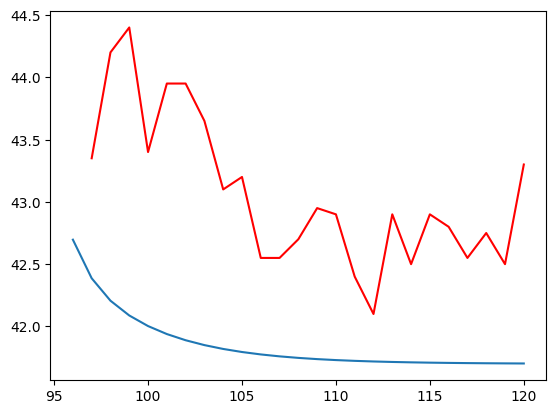

In [14]:
mod = AutoReg(y_train, lags=3)  # Assuming lag order is 3
# Fit the model
res = mod.fit()
# Predict using x_test
predictions = res.predict(start=len(y_train), end=len(y_train) + len(x_test))


plt.plot(x_test, y_test, c='r')
plt.plot(predictions)

In [15]:
MSE_ar = []

for i in range(1, 31):
    # Instantiate the AutoReg model
    mod = AutoReg(y_train, lags=i)
    # Fit the model
    res = mod.fit()
    # Predict using x_test
    predictions = res.predict(start=len(y_train), end=len(y_train) + len(x_test) - 1)
    # Calculate mean squared error
    mse = mean_squared_error(y_test, predictions)
    MSE_ar.append(mse)

best_lag = np.where(MSE_ar == np.min(MSE_ar))[0] + 1
print('Best Lag(s):', best_lag)

Best Lag(s): [1]


In [16]:
mod_op = AutoReg(data_short, lags=1)
res_op = mod_op.fit()
predictions_op = res_op.predict(start=len(data_short), end=len(data_short) + 29)  # Adjusted end index

fig_fit = go.Figure()

# Plot original data
fig_fit.add_trace(go.Scatter(x=np.arange(len(VHM)), y=VHM['VND'], mode='lines', name='Original Data'))

# Plot the shorter data used for fitting the model
x_data_short = np.arange(len(VHM) - total, len(VHM))
fig_fit.add_trace(go.Scatter(x=x_data_short, y=data_short, mode='lines', name='Short Data for Fitting'))

# Plot predicted values
x_predict = np.arange(x_data_short[-1], x_data_short[-1] + 31)
fig_fit.add_trace(go.Scatter(x=x_predict, y=predictions_op, mode='lines', name='Predictions'))

fig_fit.add_trace(go.Scatter(x=[0, len(VHM)+30], y=[47.86, 47.86],
                    mode='lines',
                    name='Balance - HightSigma'))


fig_fit.update_layout(title='AutoRegressive Model Predictions', xaxis_title='Time', yaxis_title='Value')

fig_fit.show()

In [20]:
print(np.mean(predictions_op), np.min(predictions_op), np.max(predictions_op))

42.50463640538317 42.20153093501313 43.19575109504902


# VNM

Công ty Cổ phần Sữa Việt Nam (HOSE)

In [18]:
VNM = pd.read_csv('data/2024-03-28_VNM.csv')[::-1].reset_index(drop=True)

fig_vnm = go.Figure()

fig_vnm.add_trace(go.Scatter(y=VNM['VND'],
                    mode='lines',
                    name='lines'))

fig_vnm.add_trace(go.Scatter(x=[0, len(VNM)], y=[87.17, 87.17],
                    mode='lines',
                    name='Balance'))

fig_vnm.add_trace(go.Scatter(x=[0, len(VNM)], y=[69.8, 69.8],
                    mode='lines',
                    name='Balance - HightSigma'))

fig_vnm.show()